## This final project focuses on leveraging the techniques and concepts you've learned throughout this course.
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l1_l2,l1, l2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, InceptionV3, VGG16, VGG19, Xception, InceptionResNetV2, MobileNetV2, DenseNet201, NASNetLarge, NASNetMobile

import random
random.seed(42)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/CV_final_project')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [ ]:
os.getcwd()
train_path='/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/'
test_path='/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test/'
pred_path='/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_pred/seg_pred/'

# Open Folders

now let's first check the Train folder to have a look to its content

#Checking Images
now we need to check the images sizes , to know how they look like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [ ]:

code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [ ]:
def get_image_sizes(image_path, is_subfolder=False):
    """
    This function calculates the sizes of images in the given path.

    Parameters:
    - image_path: Path where images are stored.
    - is_subfolder: Set to True if the images are in subfolders (like train/test sets).

    Returns:
    - A pandas Series with the count of each image size.
    """
    sizes = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
            for img in images:
                image = plt.imread(img)
                sizes.append(image.shape)
    else:
        files = gb.glob(pathname=str(image_path + '/*.jpg'))
        for file in files:
            image = plt.imread(file)
            sizes.append(image.shape)

    return pd.Series(sizes).value_counts()

# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

Train Image Sizes
 (150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(143, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(144, 150, 3)        2
(136, 150, 3)        2
(123, 150, 3)        2
(108, 150, 3)        2
(134, 150, 3)        2
(119, 150, 3)        1
(76, 150, 3)         1
(105, 150, 3)        1
(120, 150, 3)        1
(102, 150, 3)        1
(149, 150, 3)        1
(97, 150, 3)         1
(110, 150, 3)        1
(141, 150, 3)        1
(140, 150, 3)        1
(124, 150, 3)        1
(131, 150, 3)        1
(145, 150, 3)        1
(81, 150, 3)         1
(147, 150, 3)        1
(103, 150, 3)        1
(100, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
Name: count, dtype: int64
Test Image Sizes:
 (150, 150, 3)    2993
(149, 150, 3)       1
(72, 150, 3)        1
(76, 150, 3)        1
(110, 150, 3)       1
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
Name: count, dtype: int64
Prediction Image Size

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [ ]:
def load_images(image_path, code, resize_shape=(100, 100), is_subfolder=True):
    """
    Loads and resizes images from the specified path.

    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
    - is_subfolder: Boolean indicating if images are in subfolders (T|rue for train/test, False for prediction).

    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                # normalized_image = image_resized / 255.0
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            # image = cv2.imread(img_path)
            image = plt.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            # normalized_image = image_resized / 255.0
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)


In [ ]:
# Usage for train data
x_train_1, y_train_1 = load_images(train_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for test data
x_test_1, y_test_1 = load_images(test_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred_1, _ = load_images(pred_path, code=None, resize_shape=(150, 150), is_subfolder=False)

print(f"x_train shape: {x_train_1.shape}, y_train shape: {y_train_1.shape}")
print(f"x_test shape: {x_test_1.shape}, y_test shape: {y_test_1.shape}")
print(f"x_pred shape: {x_pred_1.shape}")

x_train shape: (14034, 150, 150, 3), y_train shape: (14034,)
x_test shape: (3000, 150, 150, 3), y_test shape: (3000,)
x_pred shape: (7301, 150, 150, 3)


In [ ]:
x_train=np.array(x_train_1)
x_test=np.array(x_test_1)

y_train = to_categorical(np.array(y_train_1), num_classes=6)
y_test = to_categorical(np.array(y_test_1), num_classes=6)

x_pred=np.array(x_pred_1)

In [ ]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

(14034, 150, 150, 3)
(3000, 150, 150, 3)
(14034, 6)
(3000, 6)
(7301, 150, 150, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)

    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = list(code.values())
    target_names = list(code.keys())

    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

# My Custom Model

In [ ]:
# Image Augmentation

train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=64
)

val_generator = val_datagen.flow(
    x_test,
    y_test,
    batch_size=64
)

In [ ]:
#implement a custom Model
KerasModel = tf.keras.models.Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    GlobalAveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(rate=0.8),
    Dense(6, activation='softmax')
])

In [ ]:
KerasModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 5,849,734 (22.31 MB)

 Trainable params: 5,846,790 (22.30 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# # We can load previous model weights if we want to continue training
# weights_saved_path = '/content/drive/MyDrive/CV_final_project/Weights/my_model.keras'
# try:
#   KerasModel.load_weights(weights_saved_path)
# except:
#   print('No previous weights found')

In [ ]:
KerasModel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Define the path where you want to save the best model
model_save_path = '/content/drive/MyDrive/CV_final_project/Weights/my_model.keras'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

# Reduce Learning rate when loss is not decreasing
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001)

# Define Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

# Train the model with the ModelCheckpoint callback
cutom_model_history = KerasModel.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),  # Make sure to include validation data
    epochs=25,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint, reduce_lr, early_stop]  # Pass the checkpoint callback here
)

Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5035 - loss: 1.4543
Epoch 1: val_loss improved from inf to 1.87273, saving model to /content/drive/MyDrive/CV_final_project/Weights/my_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 202s 736ms/step - accuracy: 0.5040 - loss: 1.4528 - val_accuracy: 0.2510 - val_loss: 1.8727 - learning_rate: 1.0000e-04
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7493 - loss: 0.6967
Epoch 2: val_loss improved from 1.87273 to 0.61738, saving model to /content/drive/MyDrive/CV_final_project/Weights/my_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 128s 557ms/step - accuracy: 0.7494 - loss: 0.6966 - val_accuracy: 0.7757 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.8070 - loss: 0.5447
Epoch 3: val_loss did not improve from 0.61738
220/220 ━━━━━━━━━━━━━━━━━━━━ 137s 537ms/step - accuracy: 0.8070 - loss: 0.5447 - val_accuracy: 0.7673 - val_loss: 0.6588 - learning_r

In [ ]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9245 - loss: 0.2428


In [ ]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.3023417592048645
accuracy is 0.9020000100135803


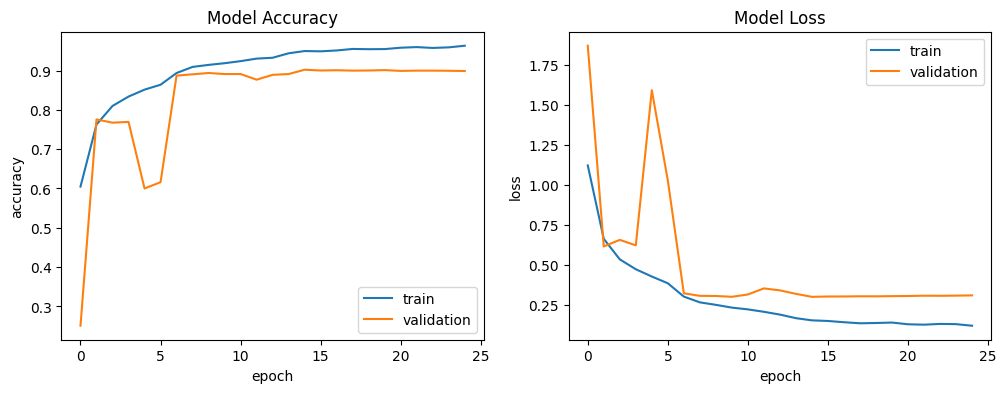

In [ ]:
plt.figure(figsize=(12,4))
#  "Accuracy"
plt.subplot(1,2,1)
plt.plot(cutom_model_history.history['accuracy'])
plt.plot(cutom_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#  "Loss"
plt.subplot(1,2,2)
plt.plot(cutom_model_history.history['loss'])
plt.plot(cutom_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


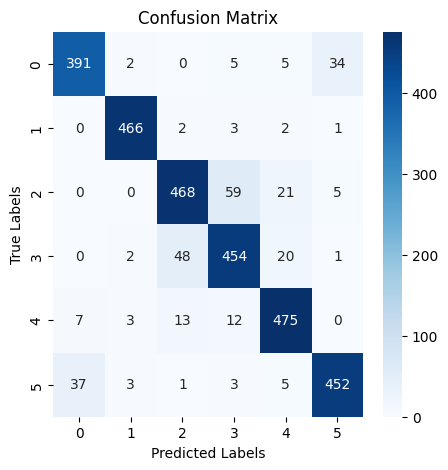

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.89      0.90       437
      forest       0.98      0.98      0.98       474
     glacier       0.88      0.85      0.86       553
    mountain       0.85      0.86      0.86       525
         sea       0.90      0.93      0.92       510
      street       0.92      0.90      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Precision: 0.9020
Recall: 0.9020
F1-score: 0.9019


In [ ]:
generate_confusion_matrix_and_metrics(KerasModel, x_test, y_test)

229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step


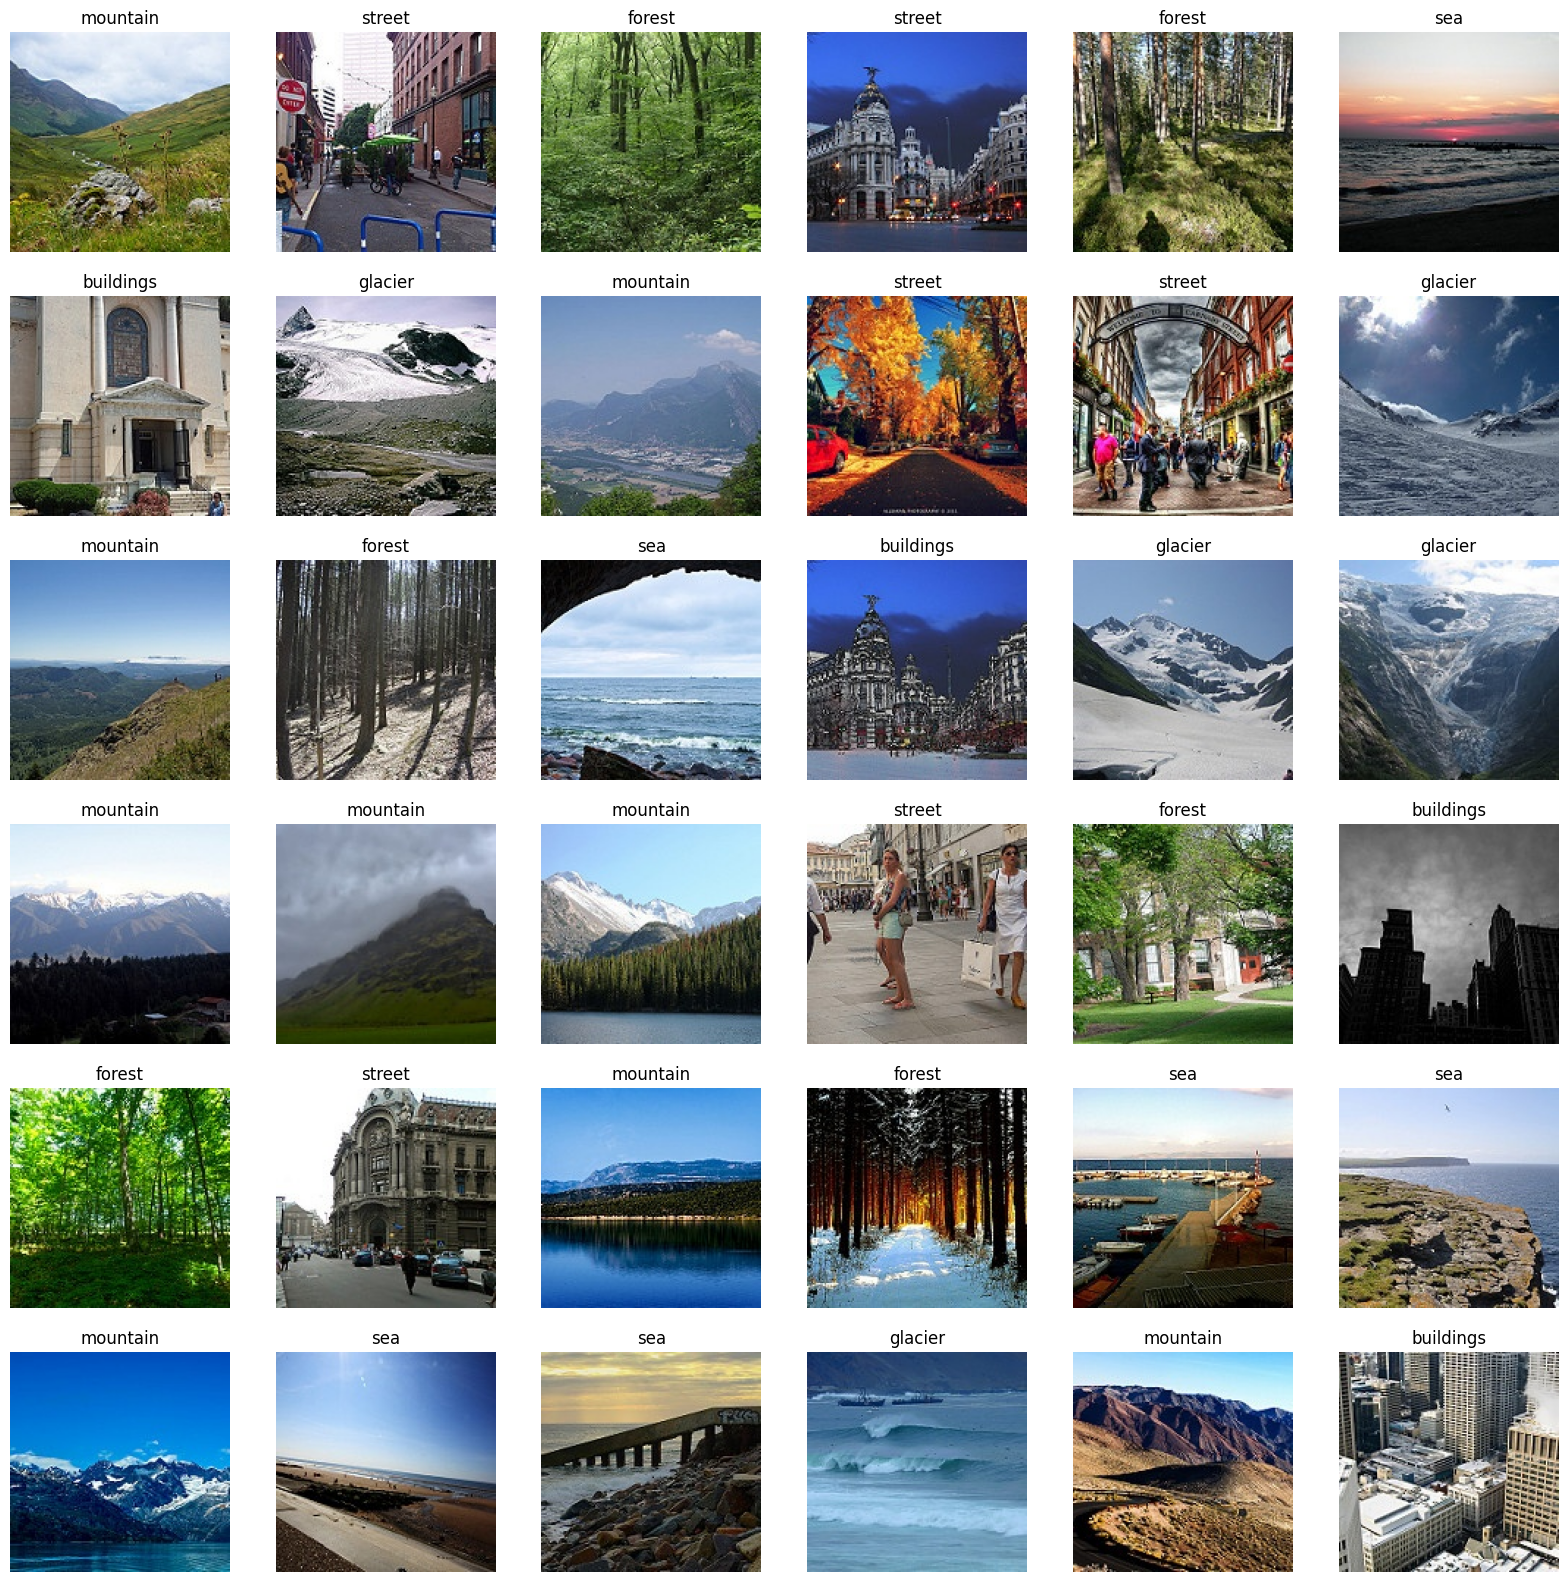

In [ ]:
y_result3 = KerasModel.predict(x_pred)
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result3[i])))

In [ ]:
KerasModel.save(f'/content/drive/MyDrive/CV_final_project/Weights/best_keras_model.h5')

In [ ]:
KerasModel.save(f'/content/drive/MyDrive/CV_final_project/Weights/best_keras_model.keras')

# Transfer Learning

In [ ]:
# Loading Images again but larger size for Transfer Learning
# Usage for train data
x_train_2, y_train_2 = load_images(train_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for test data
x_test_2, y_test_2 = load_images(test_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for prediction data (no labels)
# x_pred_2, _ = load_images(pred_path, code=None, resize_shape=(150, 150), is_subfolder=False)

In [ ]:
num_classes = 6
xx_train = x_train_2
xx_test = x_test_2
yy_train = to_categorical(np.array(y_train_2), num_classes=6)
yy_test = to_categorical(np.array(y_test_2), num_classes=6)

In [ ]:
def data_generator_function(xx_train,yy_train,xx_test , yy_test, model):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        rescale=1.0/255
    )

    # Create generators
    train_generator = train_datagen.flow(
        xx_train,
        yy_train,
        batch_size=32
    )

    val_generator = val_datagen.flow(
        xx_test,
        yy_test,
        batch_size=32
    )

    return train_generator,val_generator



In [ ]:
def my_architecture():
  #implement a custom Model
  KerasModel = tf.keras.models.Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    GlobalAveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(rate=0.8),
    Dense(6, activation='softmax')
  ])

  KerasModel.summary()
  KerasModel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  return KerasModel

In [ ]:
def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    # Now we add the new layers to the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.0005)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [ ]:
def vgg19_architecture():
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(150,150, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
      layer.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [ ]:
def resnet152v2_architecture():
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(150,150, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.001)
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model

In [ ]:
def inception_v3_architecture():

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(150,150, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [ ]:
def DenseNet_201_architecture():

    base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(150,150, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    DenseNet_model = Model(inputs=base_model.input, outputs=output)

    DenseNet_model.summary()

    optimizer = Adam(learning_rate=0.001)
    DenseNet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return DenseNet_model

In [ ]:
def evaluate_model(model, x_test, yy_test):
    loss, accuracy = model.evaluate(x_test, yy_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

Training VGG16...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 24,172,358 (92.21 MB)

 Trainable params: 9,456,646 (36.07 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7215 - loss: 0.7364
Epoch 1: val_loss improved from inf to 0.43629, saving model to /content/drive/MyDrive/CV_final_project/Weights/VGG16.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 124s 256ms/step - accuracy: 0.7216 - loss: 0.7361 - val_accuracy: 0.8280 - val_loss: 0.4363 - learning_rate: 5.0000e-04
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8143 - loss: 0.5155
Epoch 2: val_loss improved from 0.43629 to 0.37751, saving model to /content/drive/MyDrive/CV_final_project/Weights/VGG16.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 98s 223ms/step - accuracy: 0.8143 - loss: 0.5155 - val_accuracy: 0.8633 - val_loss: 0.3775 - learning_rate: 5.0000e-04
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8293 - loss: 0.4660
Epoch 3: val_loss did not improve from 0.37751
439/439 ━━━━━━━━━━━━━━━━━━━━ 98s 223ms/step - accuracy: 0.8293 - loss: 0.4660 - val_accuracy: 0.8520 - val_loss: 0.3911 - learning_rate: 5.0

Evaluating VGG16...
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.8989 - loss: 0.2862
Loss: 0.3276730477809906
Accuracy: 0.8769999742507935
VGG16 evaluation complete.
Accuracy: 0.8769999742507935

_______________________________________________________________________


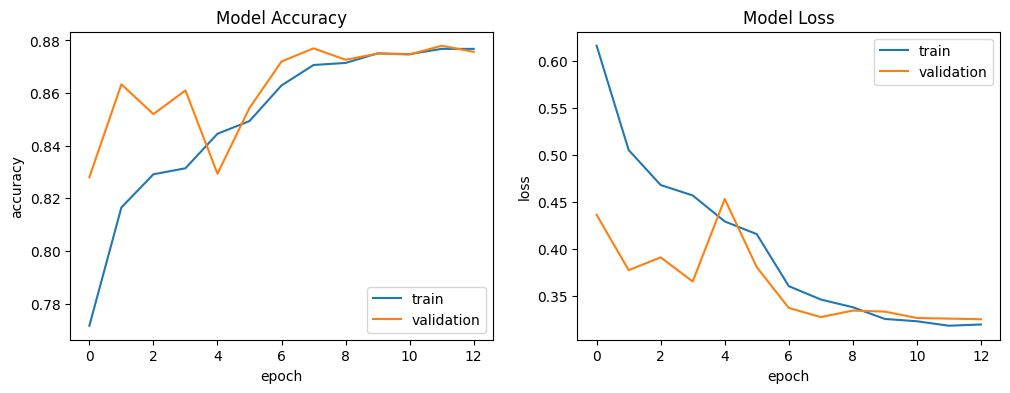

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


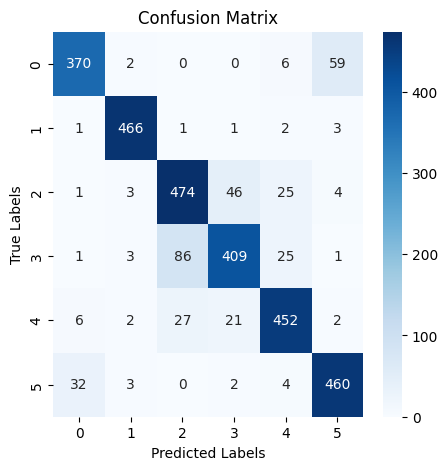

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.85      0.87       437
      forest       0.97      0.98      0.98       474
     glacier       0.81      0.86      0.83       553
    mountain       0.85      0.78      0.81       525
         sea       0.88      0.89      0.88       510
      street       0.87      0.92      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000

Precision: 0.8776
Recall: 0.8770
F1-score: 0.8766


In [ ]:
models = {
     "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    #  "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    bst_model_path = f'/content/drive/MyDrive/CV_final_project/Weights/{model_name}.keras'

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        bst_model_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.h5')
    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.keras')

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

Training VGG19...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,285,702 (96.46 MB)

 Trainable params: 5,260,294 (20.07 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7213 - loss: 0.7924
Epoch 1: val_loss improved from inf to 0.45728, saving model to /content/drive/MyDrive/CV_final_project/Weights/VGG19.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 155s 331ms/step - accuracy: 0.7214 - loss: 0.7921 - val_accuracy: 0.8280 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7916 - loss: 0.5416
Epoch 2: val_loss improved from 0.45728 to 0.41100, saving model to /content/drive/MyDrive/CV_final_project/Weights/VGG19.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 237ms/step - accuracy: 0.7916 - loss: 0.5416 - val_accuracy: 0.8517 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8073 - loss: 0.5152
Epoch 3: val_loss improved from 0.41100 to 0.39897, saving model to /content/drive/MyDrive/CV_final_project/Weights/VGG19.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 114s 259ms/step - accuracy: 0.8073 - 

Evaluating VGG19...
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.8618 - loss: 0.3949
Loss: 0.3371179401874542
Accuracy: 0.8786666393280029
VGG19 evaluation complete.
Accuracy: 0.8786666393280029

_______________________________________________________________________


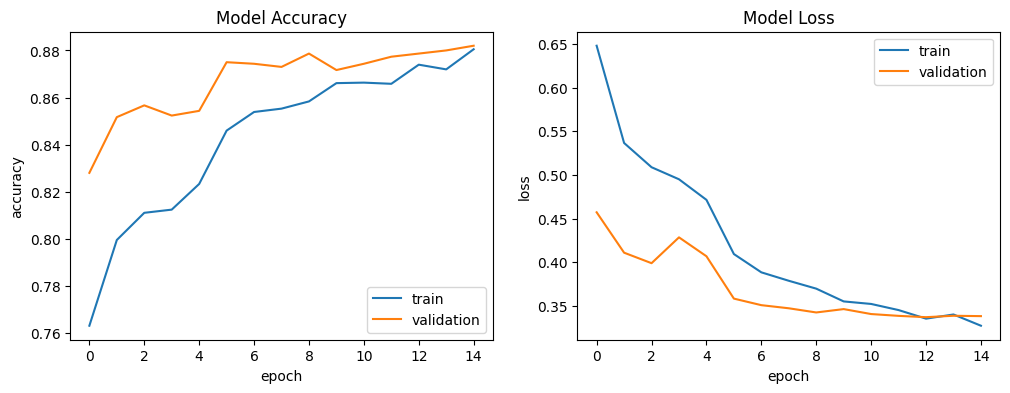

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


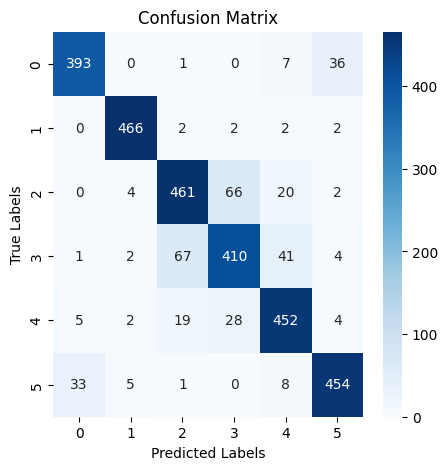

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.90      0.90       437
      forest       0.97      0.98      0.98       474
     glacier       0.84      0.83      0.84       553
    mountain       0.81      0.78      0.80       525
         sea       0.85      0.89      0.87       510
      street       0.90      0.91      0.91       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000

Precision: 0.8783
Recall: 0.8787
F1-score: 0.8784


In [ ]:
models = {
    #  "VGG16": vgg16_architecture,
     "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    bst_model_path = f'/content/drive/MyDrive/CV_final_project/Weights/{model_name}.keras'

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        bst_model_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.h5')
    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.keras')

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

Training ResNet152V2...
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 38, 38, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 38, 38, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 40, 40, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 67,784,710 (258.58 MB)

 Trainable params: 9,448,966 (36.04 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7634 - loss: 0.7376
Epoch 1: val_loss improved from inf to 0.35381, saving model to /content/drive/MyDrive/CV_final_project/Weights/ResNet152V2.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 180s 332ms/step - accuracy: 0.7635 - loss: 0.7371 - val_accuracy: 0.8720 - val_loss: 0.3538 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8549 - loss: 0.4029
Epoch 2: val_loss improved from 0.35381 to 0.32796, saving model to /content/drive/MyDrive/CV_final_project/Weights/ResNet152V2.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 152s 244ms/step - accuracy: 0.8549 - loss: 0.4029 - val_accuracy: 0.8767 - val_loss: 0.3280 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8711 - loss: 0.3561
Epoch 3: val_loss improved from 0.32796 to 0.32785, saving model to /content/drive/MyDrive/CV_final_project/Weights/ResNet152V2.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 110s 246ms/step - accuracy: 0.

Evaluating ResNet152V2...
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.8998 - loss: 0.2921
Loss: 0.2590234577655792
Accuracy: 0.9056666493415833
ResNet152V2 evaluation complete.
Accuracy: 0.9056666493415833

_______________________________________________________________________


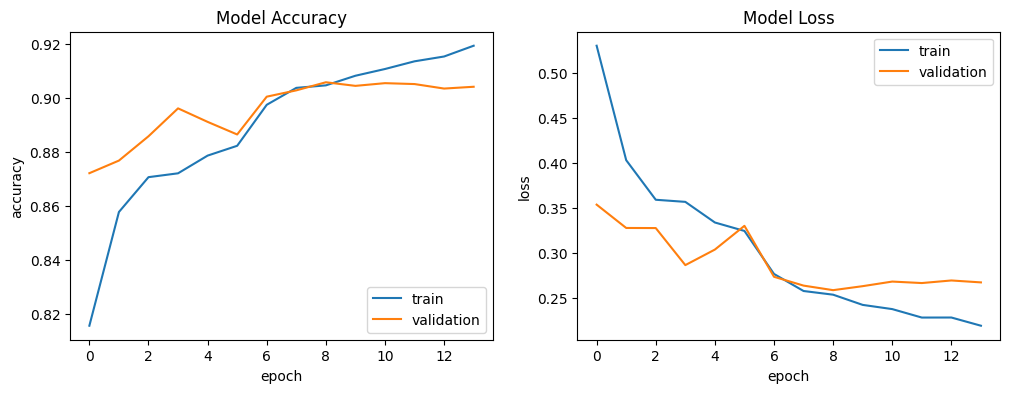

94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


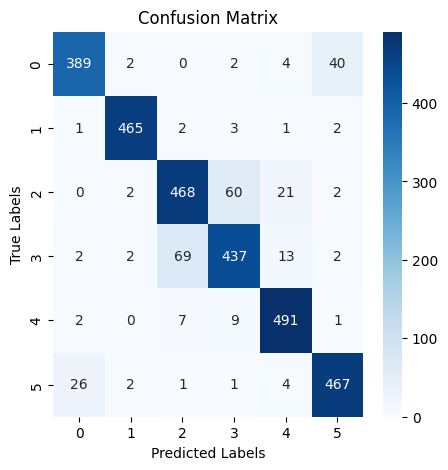

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.89      0.91       437
      forest       0.98      0.98      0.98       474
     glacier       0.86      0.85      0.85       553
    mountain       0.85      0.83      0.84       525
         sea       0.92      0.96      0.94       510
      street       0.91      0.93      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Precision: 0.9054
Recall: 0.9057
F1-score: 0.9053


In [ ]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    bst_model_path = f'/content/drive/MyDrive/CV_final_project/Weights/{model_name}.keras'

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        bst_model_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.h5')
    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.keras')

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

Training InceptionV3...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 31,255,846 (119.23 MB)

 Trainable params: 9,448,966 (36.04 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7334 - loss: 0.8691
Epoch 1: val_loss improved from inf to 0.40569, saving model to /content/drive/MyDrive/CV_final_project/Weights/InceptionV3.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 125s 238ms/step - accuracy: 0.7337 - loss: 0.8679 - val_accuracy: 0.8417 - val_loss: 0.4057 - learning_rate: 0.0010
Epoch 2/30
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8438 - loss: 0.4415
Epoch 2: val_loss improved from 0.40569 to 0.39209, saving model to /content/drive/MyDrive/CV_final_project/Weights/InceptionV3.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 119s 205ms/step - accuracy: 0.8438 - loss: 0.4415 - val_accuracy: 0.8573 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8414 - loss: 0.4357
Epoch 3: val_loss improved from 0.39209 to 0.33143, saving model to /content/drive/MyDrive/CV_final_project/Weights/InceptionV3.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.

Evaluating InceptionV3...
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9274 - loss: 0.2217
Loss: 0.25493523478507996
Accuracy: 0.9100000262260437
InceptionV3 evaluation complete.
Accuracy: 0.9100000262260437

_______________________________________________________________________


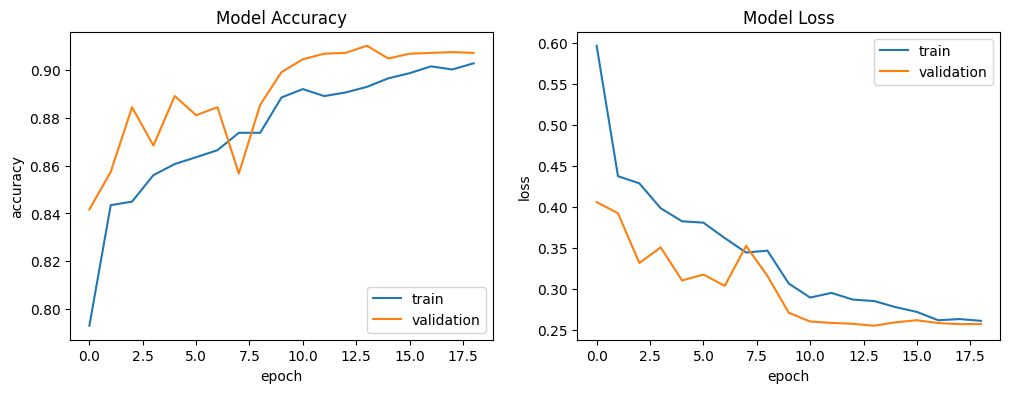

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


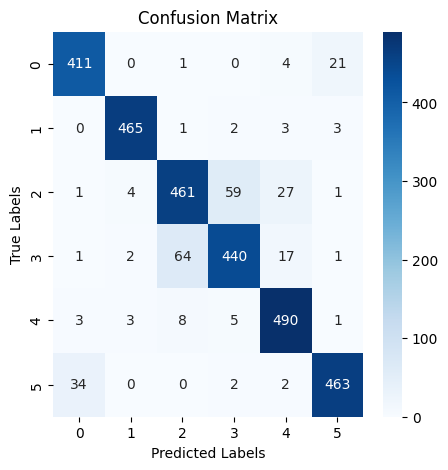

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.94      0.93       437
      forest       0.98      0.98      0.98       474
     glacier       0.86      0.83      0.85       553
    mountain       0.87      0.84      0.85       525
         sea       0.90      0.96      0.93       510
      street       0.94      0.92      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Precision: 0.9097
Recall: 0.9100
F1-score: 0.9095


In [ ]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
     "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    bst_model_path = f'/content/drive/MyDrive/CV_final_project/Weights/{model_name}.keras'

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        bst_model_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.h5')
    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.keras')

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

Training DenseNet...
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 38, 38, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 38, 38, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 38, 38, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 23,316,038 (88.94 MB)

 Trainable params: 4,990,214 (19.04 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7993 - loss: 0.5584
Epoch 1: val_loss improved from inf to 0.31260, saving model to /content/drive/MyDrive/CV_final_project/Weights/DenseNet.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 226s 403ms/step - accuracy: 0.7994 - loss: 0.5581 - val_accuracy: 0.8807 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 2/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8813 - loss: 0.3232
Epoch 2: val_loss improved from 0.31260 to 0.24243, saving model to /content/drive/MyDrive/CV_final_project/Weights/DenseNet.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - accuracy: 0.8813 - loss: 0.3232 - val_accuracy: 0.9070 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 3/25
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8891 - loss: 0.3078
Epoch 3: val_loss did not improve from 0.24243
439/439 ━━━━━━━━━━━━━━━━━━━━ 137s 230ms/step - accuracy: 0.8891 - loss: 0.3078 - val_accuracy: 0.9087 - val_loss: 0.2490 - learning_rate: 0.0

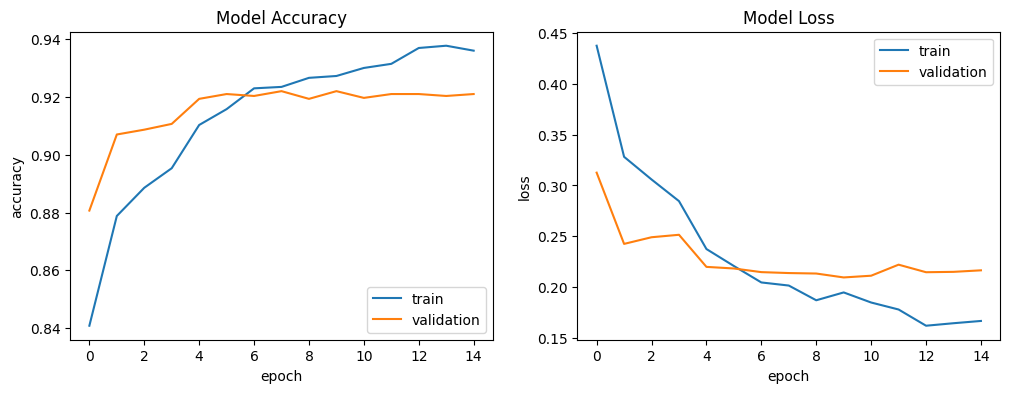

Evaluating DenseNet...
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.9499 - loss: 0.1452
Loss: 0.20937782526016235
Accuracy: 0.921999990940094
DenseNet evaluation complete.
Accuracy: 0.921999990940094

_______________________________________________________________________
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 300ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


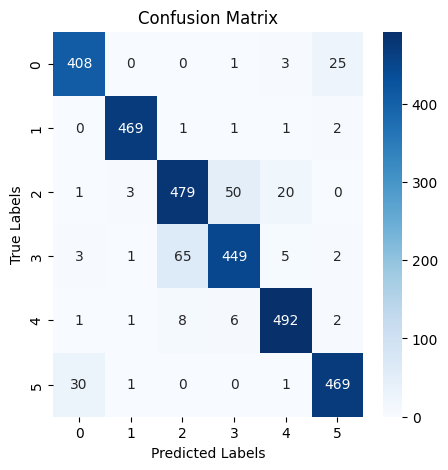

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.93      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.87      0.87      0.87       553
    mountain       0.89      0.86      0.87       525
         sea       0.94      0.96      0.95       510
      street       0.94      0.94      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Precision: 0.9217
Recall: 0.9220
F1-score: 0.9218


In [ ]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    bst_model_path = f'/content/drive/MyDrive/CV_final_project/Weights/{model_name}.keras'

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        bst_model_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.h5')
    model.save(f'/content/drive/MyDrive/CV_final_project/Weights/best{model_name}_model.keras')

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")



    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

# Ensemble of Models

In [ ]:
def generate_confusion_matrix_and_metrics_ensemble(y_test, ensemble_results_classes, code):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, ensemble_results_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = list(code.values())
    target_names = list(code.keys())

    report = classification_report(y_test, ensemble_results_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, ensemble_results_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

In [ ]:
# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(150, 150), is_subfolder=True)

x_test=np.array(x_test)

models_names = { 'My-Net': 'best_keras_model.h5',
                'VGG-16': 'bestVGG16_model.h5',
                'VGG-19': 'bestVGG16_model.h5',
                'ResNet': 'bestResNet152V2_model.h5',
                'Inception': 'bestInceptionV3_model.h5',
                'DenseNet': 'bestDenseNet_model.h5'}

In [ ]:
results = {}

for model in models_names.keys():
    print('Loading:',model, '...')
    crnt_model = load_model(f'/content/drive/MyDrive/CV_final_project/Weights/{models_names[model]}')
    if model != 'My-Net':
        x_test_n = x_test/255.0
    else:
        x_test_n = x_test
    prediction = crnt_model.predict(x_test_n)
    results[model] = prediction


Loading: My-Net ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step
Loading: VGG-16 ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step
Loading: VGG-19 ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step
Loading: ResNet ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step
Loading: Inception ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 483ms/step
Loading: DenseNet ...


94/94 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step


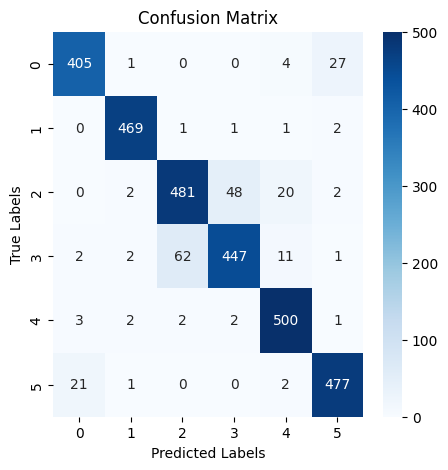

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.88      0.87      0.88       553
    mountain       0.90      0.85      0.87       525
         sea       0.93      0.98      0.95       510
      street       0.94      0.95      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Precision: 0.9259
Recall: 0.9263
F1-score: 0.9259


In [ ]:
# Average ensemble with all models
avg_ensemble_results = (results['My-Net'] + results['VGG-16'] + results['VGG-19'] + results['ResNet'] + results['Inception'] + results['DenseNet']) / 6
avg_ensemble_classes = np.argmax(avg_ensemble_results, axis=1)
confidence = np.max(avg_ensemble_results, axis=1) * 100
generate_confusion_matrix_and_metrics_ensemble(y_test, avg_ensemble_classes, code)

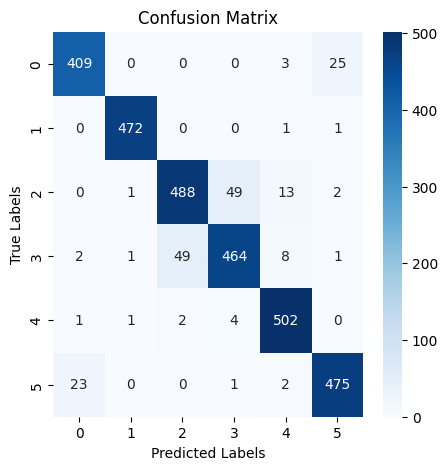

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.94      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.91      0.88      0.89       553
    mountain       0.90      0.88      0.89       525
         sea       0.95      0.98      0.97       510
      street       0.94      0.95      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000

Precision: 0.9363
Recall: 0.9367
F1-score: 0.9364


In [ ]:
# Average ensemble with best 3 models
avg_ensemble2_results = (results['My-Net']  + results['ResNet']  + results['DenseNet']) / 3
avg_ensemble2_classes = np.argmax(avg_ensemble2_results, axis=1)
confidence2 = np.max(avg_ensemble2_results, axis=1) * 100
generate_confusion_matrix_and_metrics_ensemble(y_test, avg_ensemble2_classes, code)

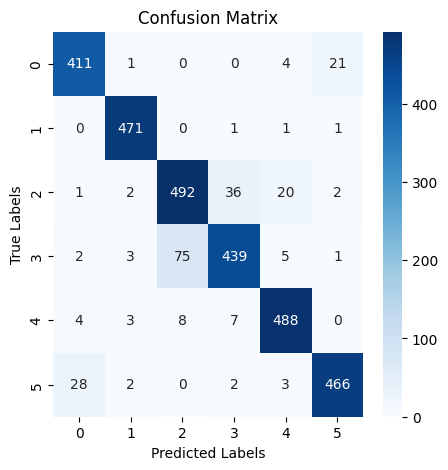

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.94      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.86      0.89      0.87       553
    mountain       0.91      0.84      0.87       525
         sea       0.94      0.96      0.95       510
      street       0.95      0.93      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Precision: 0.9225
Recall: 0.9223
F1-score: 0.9221


In [ ]:
# Voting ensemble with all models
my_net_classes = to_categorical(np.argmax(results['My-Net'], axis=1), num_classes=6)
vgg16_classes = to_categorical(np.argmax(results['VGG-16'], axis=1), num_classes=6)
vgg19_classes = to_categorical(np.argmax(results['VGG-19'], axis=1), num_classes=6)
resnet_classes = to_categorical(np.argmax(results['ResNet'], axis=1), num_classes=6)
inception_classes = to_categorical(np.argmax(results['Inception'], axis=1), num_classes=6)
densenet_classes = to_categorical(np.argmax(results['DenseNet'], axis=1), num_classes=6)


voting_ensemble_classes = (my_net_classes + vgg16_classes + vgg19_classes + resnet_classes + inception_classes + densenet_classes)
voting_ensemble_classes = np.argmax(voting_ensemble_classes, axis=1)
generate_confusion_matrix_and_metrics_ensemble(y_test, voting_ensemble_classes, code)

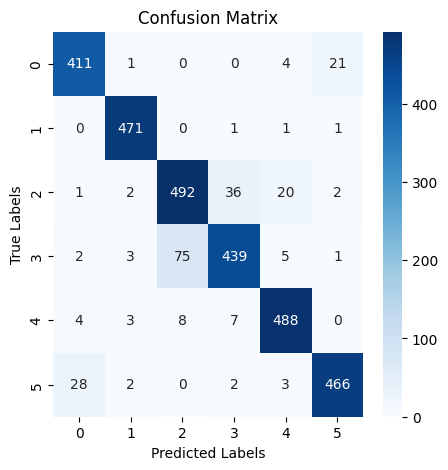

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.94      0.93       437
      forest       0.98      0.99      0.99       474
     glacier       0.86      0.89      0.87       553
    mountain       0.91      0.84      0.87       525
         sea       0.94      0.96      0.95       510
      street       0.95      0.93      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Precision: 0.9225
Recall: 0.9223
F1-score: 0.9221


In [ ]:
# Voting ensemble with all models
my_net_classes = to_categorical(np.argmax(results['My-Net'], axis=1), num_classes=6)
vgg16_classes = to_categorical(np.argmax(results['VGG-16'], axis=1), num_classes=6)
vgg19_classes = to_categorical(np.argmax(results['VGG-19'], axis=1), num_classes=6)
resnet_classes = to_categorical(np.argmax(results['ResNet'], axis=1), num_classes=6)
inception_classes = to_categorical(np.argmax(results['Inception'], axis=1), num_classes=6)
densenet_classes = to_categorical(np.argmax(results['DenseNet'], axis=1), num_classes=6)


voting_ensemble_classes = (my_net_classes + vgg16_classes + vgg19_classes + resnet_classes + inception_classes + densenet_classes)
voting_ensemble_classes = np.argmax(voting_ensemble_classes, axis=1)
generate_confusion_matrix_and_metrics_ensemble(y_test, voting_ensemble_classes, code)

## Final Models Comparison Table

| Network                         | Accuracy | Recall | Precision | F1-Score |
|---------------------------------|----------|--------|-----------|----------|
| Your CNN model                  |   90%    |   90%  |    90%    |   90%    |
| VGG16                           |   88%    |   88%  |    88%    |   88%    |
| VGG19                           |   88%    |   88%  |    88%    |   88%    |
| Inception_V3                    |   91%    |   91%  |    91%    |   91%    |
| RasNet152V2                     |   91%    |   91%  |    91%    |   91%    |
| DenseNet201                     |   92%    |   92%  |    92%    |   92%    |
| Voting Ensemble (All models)    |   92%    |   92%  |    92%    |   92%    |
| Voting Ensemble (Top 3 models)  |   93%    |   93%  |    93%    |   93%    |
| Average Ensemble (All models)   |   93%    |   93%  |    93%    |   93%    |
| Average Ensemble (Top 3 models) |   94%    |   94%  |    94%    |   94%    |



**As we can see from the results above: The "Average Ensemble" using (My-Net , ResNet , DenseNet) produced the best results on the test dataset with approximately 94% for all classification metrics**